# Kernel-based training of quantum models

Over the last few years, it has been increaing clear that mathematical foundations of quantum models are intimately related to kernel-method. In this tutorial, I will use 2 methods of QML, well known variational quantum circuit and alternative kernel based circuit, to train for classic iris datasets.

Prepare iris dataset.

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
from pennylane.operation import Tensor

import torch
from torch.nn.functional import relu

from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
np.random.seed(1)

In [4]:
X, y = load_iris(return_X_y = True)
X = X[:100]
y = y[:100]

scaler = StandardScaler().fit(X)

X_scaled = scaler.transform(X)
y_scaled = 2 * (y - 0.5)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled)

In [5]:
n_qubits = len(X_train[0])

Now we have our dataset ready, let's try original variational circuit approach to train for the dataset.

### 1. Variational Circuit Model

In [8]:
dev_var = qml.device("default.qubit", wires = n_qubits)

In [25]:
@qml.qnode(dev_var, interface = "torch", diff_method="parameter-shift")
def quantum_model(x, params):
    AngleEmbedding(x, wires = range(n_qubits))
    StronglyEntanglingLayers(params, wires = range(n_qubits))
    return qml.expval(qml.PauliZ(0))

def quantum_model_plus_bias(x, params, bias):
    return quantum_model(x, params) + bias

def hinge_loss(predictions, targets):
    all_ones = torch.ones_like(targets)
    hinge_loss = all_ones - predictions * targets
    hinge_loss = relu(hinge_loss)
    return hinge_loss

In [35]:
def quantum_model_train(n_layers, steps, batch_size):
    params = np.random.random((n_layers, n_qubits, n_qubits - 1))
    params_torch = torch.tensor(params, requires_grad = True)
    bias_torch = torch.tensor(0.0)
    
    opt = torch.optim.Adam([params_torch, bias_torch], lr = 0.1)
    loss_history = []
    
    for i in range(steps):
        batch_ids = np.random.choice(len(X_train), batch_size)
        
        X_batch = X_train[batch_ids]
        y_batch = y_train[batch_ids]
        
        X_batch_torch = torch.tensor(X_batch, requires_grad = False)
        y_batch_torch = torch.tensor(y_batch, requires_grad = False)
        
        def closure():
            opt.zero_grad()
            preds = torch.stack(
            [quantum_model_plus_bias(x, params_torch, bias_torch) for x in X_batch_torch])
            loss = torch.mean(hinge_loss(preds, y_batch_torch))
            
            current_loss = loss.detach().numpy().item()
            loss_history.append(current_loss)
            
            if i % 10 == 0:
                print("steps", i, ", loss", current_loss)
            loss.backward()
            return loss
        
        opt.step(closure)
    return params_torch, bias_torch, loss_history

In [36]:
def quantum_model_predict(X_pred, trained_params, trained_bias):
    preds = []
    for x in X_test:
        pred_torch = quantum_model_plus_bias(x, trained_params, trained_bias)
        pred = pred_torch.detach().numpy().item()
        if pred > 0:
            pred = 1
        else:
            pred = -1
            
        preds.append(pred)
    return preds

Now we can train our strongly entangled quantum circuit.

In [40]:
n_layers = 2
batch_size = 20
steps = 100
trained_params, trained_bias, loss_history = quantum_model_train(n_layers, steps, batch_size)

pred_test = quantum_model_predict(X_test, trained_params, trained_bias)
print("accuracy on the test set: ", accuracy_score(pred_test, y_test))

steps 0 , loss 1.1211535230421803
steps 10 , loss 0.6864388950461567
steps 20 , loss 0.7668317494182858
steps 30 , loss 0.5923159556750777
steps 40 , loss 0.6461640084741354
steps 50 , loss 0.5028081458226811
steps 60 , loss 0.5775658853040488
steps 70 , loss 0.4242429826468683
steps 80 , loss 0.5413930234898553
steps 90 , loss 0.484447638033345
accuracy on the test set:  0.96


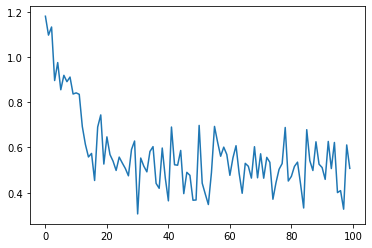

In [39]:
plt.plot(loss_function)
plt.ylim((0,1))
plt.xlabel("steps")
plt.ylabel("cost")
plt.show()

The quantum circuit is successfully trained for the iris dataset. We can check the numbers of quantum function execution in the device,

In [41]:
n_exe = dev_var.num_executions
print(n_exe, " numbers of quantum functions were executed during training process.")

150340  numbers of quantum functions were executed during training process
